In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm, multivariate_normal, binom

import pymc3 as pm
import arviz as az

## Water example

Data

In [2]:
n = 9
x = 6

Declare and fit the model.

In [3]:
with pm.Model() as model_water:
    theta = pm.Uniform('theta', 0, 1)
    water = pm.Binomial('water', n=n, p=theta, observed=x)

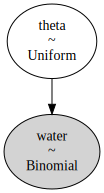

In [4]:
pm.model_to_graphviz(model_water)

Using the normal approximation

In [5]:
with model_water:
    mean_q = pm.find_MAP()
    IFisher = pm.find_hessian(mean_q, vars=[theta])
    std_q = (1/IFisher**0.5)[0]

mean_q['theta'], std_q

(array(0.66666667), array([0.15713484]))

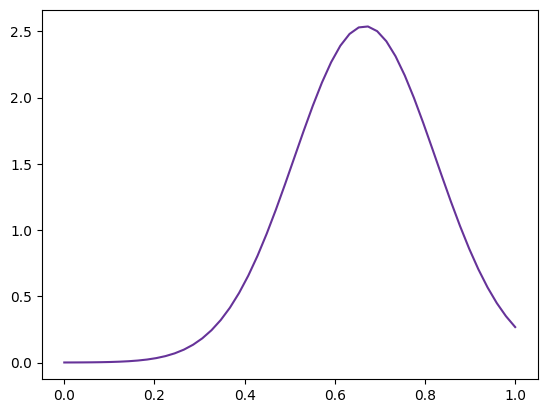

In [6]:
theta_grid = np.linspace(0,1)
posterior_quadratic_approx = norm.pdf(theta_grid, mean_q['theta'], std_q)
plt.plot(theta_grid, posterior_quadratic_approx, color='rebeccapurple')

Sample from the approximate normal posterior.

In [7]:
n_posterior = 10**4
posterior_sample = norm.rvs(size=n_posterior, loc=mean_q['theta'], scale=std_q)
posterior_sample = posterior_sample[(posterior_sample<1) & (posterior_sample>0)]

Posterior interval of 0.5 of probability.

In [8]:
np.quantile(posterior_sample, [0.25, 0.75])

array([0.5589713 , 0.76633707])

Sample from the posterior predictive.

In [9]:
water_posterior = binom.rvs(size=len(posterior_sample), n=n, p=posterior_sample)

Posterior predictive interval of 0.5 of probability.

In [10]:
np.quantile(water_posterior, [0.25, 0.75])

array([5., 7.])

Using MCMC

In [11]:
with model_water:
    trace_theta = pm.sample()
    trace_water = pm.sample_posterior_predictive(trace_theta)

/tmp/ipykernel_4849/1240514057.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_theta = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


Posterior interval of 0.5 of probability.

In [12]:
az.summary(trace_theta, hdi_prob=0.5)

Got error No model on context stack. trying to find log_likelihood in translation.
/home/dmitri/.local/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_25%,hdi_75%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.636,0.143,0.542,0.743,0.003,0.003,1671.0,2421.0,1.0


In [13]:
az.hdi(trace_theta['theta'], hdi_prob=0.5)

array([0.54205976, 0.74333073])

Posterior predictive interval of 0.5 of probability.

In [14]:
az.summary(trace_water, hdi_prob=0.5)

arviz - WARNING - Shape validation failed: input_shape: (1, 4000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_25%,hdi_75%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
water,5.71,1.907,5.0,7.0,0.04,0.029,2219.0,3593.0,NaN


In [15]:
az.hdi(trace_water['water'], hdi_prob=0.5)

array([5, 7])

## Height example

Data

In [16]:
dat = pd.read_csv('Howell1.csv', sep=';')

# We are interested in adult's height
dat_adults = dat[dat['age'] >= 18]

Declare and fit the model.

In [17]:
with pm.Model() as model_height:
    mu      = pm.Normal('mu', mu=170, sd=10)
    sigma   = pm.Uniform('sigma', lower=0, upper=33)
    height  = pm.Normal('height', mu=mu, sd=sigma, observed=dat_adults['height'])

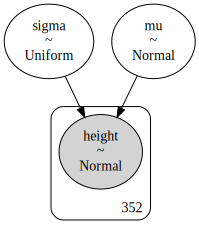

In [18]:
pm.model_to_graphviz(model_height)

Using the normal approximation.

In [19]:
with model_height:
    mean_q  = pm.find_MAP()
    IFisher = pm.find_hessian(mean_q, vars=[mu, sigma])

IFisher_inverse = np.linalg.inv(IFisher)

Sample from the approximate normal posterior.

In [20]:
posterior_sample = multivariate_normal.rvs(
    size=10**3,
    mean=np.array([mean_q['mu'], mean_q['sigma']]),
    cov=IFisher_inverse
    )

posterior_sample = pd.DataFrame(posterior_sample, columns=['mu', 'sigma'])

/home/dmitri/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, '$\\sigma$')

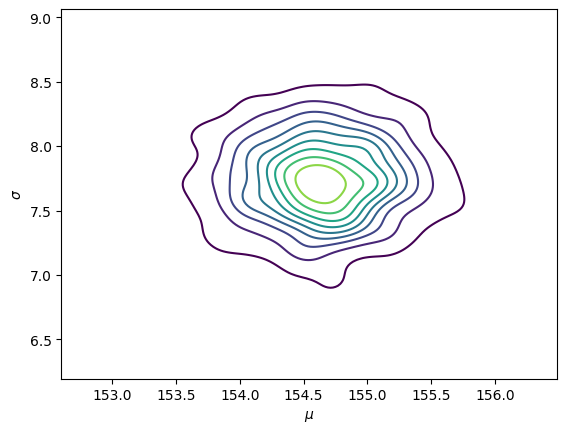

In [21]:
fig, ax = plt.subplots()
sns.kdeplot(posterior_sample['mu'], posterior_sample['sigma'], 
            cmap=plt.cm.viridis, ax=ax, n_levels=10)
ax.set_xlabel(r'$\mu$')
ax.set_ylabel(r'$\sigma$')

Posterior interval of 0.5 of probability.

In [22]:
posterior_sample.quantile([0.25,0.75])

,mu,sigma
0.25,154.378471,7.547663
0.75,154.928662,7.941787


Sample from the posterior predictive.

In [23]:
height_posterior = norm.rvs(size=len(posterior_sample), loc=posterior_sample['mu'], scale=posterior_sample['sigma'])

Posterior predictive interval of 0.5 of probability.

In [24]:
np.quantile(height_posterior, [0.25, 0.75])

array([149.4190893 , 160.03248981])

Using MCMC

In [25]:
with model_height:
    trace_posterior = pm.sample()
    trace_height = pm.sample_posterior_predictive(trace_posterior)

/tmp/ipykernel_4849/3720768528.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_posterior = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
/home/dmitri/.local/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:>, None],
       [<AxesSubplot:xlabel='mu', ylabel='sigma'>, <AxesSubplot:>]],
      dtype=object)

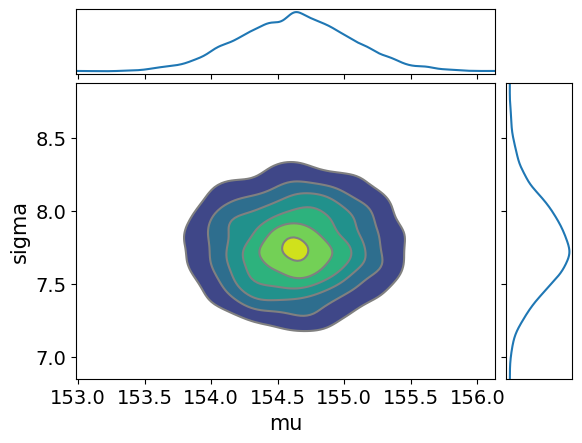

In [26]:
az.plot_pair(
    trace_posterior,
    kind="kde",
    marginals=True
)

Got error No model on context stack. trying to find log_likelihood in translation.
/home/dmitri/.local/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:>, None],
       [<AxesSubplot:xlabel='mu', ylabel='sigma'>, <AxesSubplot:>]],
      dtype=object)

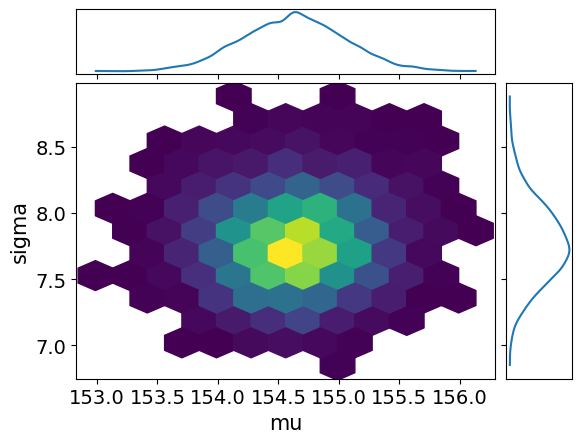

In [27]:
az.plot_pair(
    trace_posterior,
    kind="hexbin",
    marginals=True
)

Posterior interval of 0.5 of probability.

In [28]:
az.summary(trace_posterior, hdi_prob=0.5)

Got error No model on context stack. trying to find log_likelihood in translation.
/home/dmitri/.local/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_25%,hdi_75%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,154.626,0.424,154.343,154.907,0.007,0.005,3499.0,2686.0,1.0
sigma,7.769,0.293,7.542,7.931,0.005,0.004,3478.0,3021.0,1.0


Posterior predictive interval of 0.5 of probability for each person.

(Only show the first 10).

In [29]:
az.hdi(trace_height['height'], hdi_prob=0.5)[:10]

/tmp/ipykernel_4849/2526077738.py:1: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  az.hdi(trace_height['height'], hdi_prob=0.5)[:10]


array([[149.91786943, 160.12058241],
       [149.61960716, 159.69477961],
       [149.79145406, 160.28816607],
       [149.58641704, 159.88506825],
       [149.56597316, 159.96610533],
       [150.19712343, 161.00869006],
       [148.69179423, 159.21258096],
       [149.16925438, 159.69761382],
       [149.79273208, 160.15465614],
       [150.524689  , 160.85080284]])

## Regression for adults' weights

Declare and fit the model.

In [30]:
with pm.Model() as model_height_weight:
    alpha    = pm.Normal('alpha', mu=170, sd=10)
    beta     = pm.Lognormal('beta', mu=0, sigma=1)
    sigma    = pm.Uniform('sigma', lower=0, upper=33)
    mu       = pm.Deterministic('mu', alpha + beta*(dat_adults['weight']-dat_adults['weight'].mean()))
    height   = pm.Normal('height', mu=mu, sd=sigma, observed=dat_adults['height'])
    

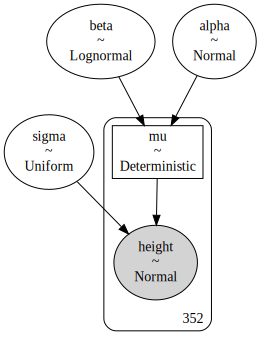

In [31]:
pm.model_to_graphviz(model_height_weight)

Using the normal approximation.

In [32]:
with model_height_weight:
    mean_q = pm.find_MAP()
    IFisher  = pm.find_hessian(mean_q, vars=[alpha, beta, sigma])

IFisher_inverse = np.linalg.inv(IFisher)

Sample from the approximate normal posterior.

In [33]:
posterior_sample = multivariate_normal.rvs(
    size=10**3,
    mean=np.array([mean_q['alpha'], mean_q['beta'], mean_q['sigma']]),
    cov=IFisher_inverse
    )

posterior_sample = pd.DataFrame(posterior_sample, columns=['alpha', 'beta', 'sigma'])

/home/dmitri/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, '$\\beta$')

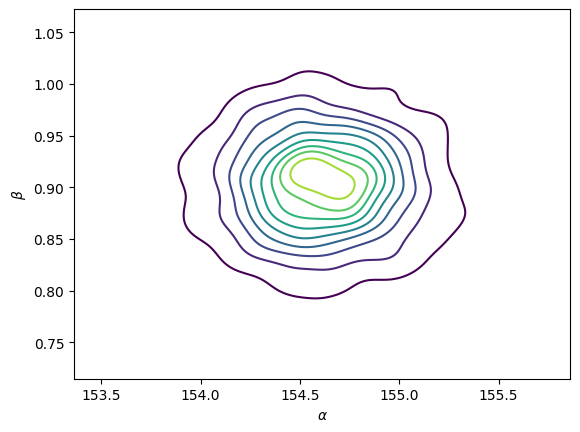

In [34]:
fig, ax = plt.subplots()
sns.kdeplot(posterior_sample['alpha'], posterior_sample['beta'], 
            cmap=plt.cm.viridis, ax=ax, n_levels=10)
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\beta$')

Posterior interval of 0.5 of probability.

In [35]:
posterior_sample.quantile([0.25,0.75])

,alpha,beta,sigma
0.25,154.421333,0.874016,4.94445
0.75,154.789220,0.930164,5.20549


Using MCMC

In [36]:
with model_height_weight:
    trace_posterior = pm.sample()
    trace_height = pm.sample_posterior_predictive(trace_posterior)

/tmp/ipykernel_4849/577785838.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_posterior = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
/home/dmitri/.local/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:>, None],
       [<AxesSubplot:xlabel='alpha', ylabel='beta'>, <AxesSubplot:>]],
      dtype=object)

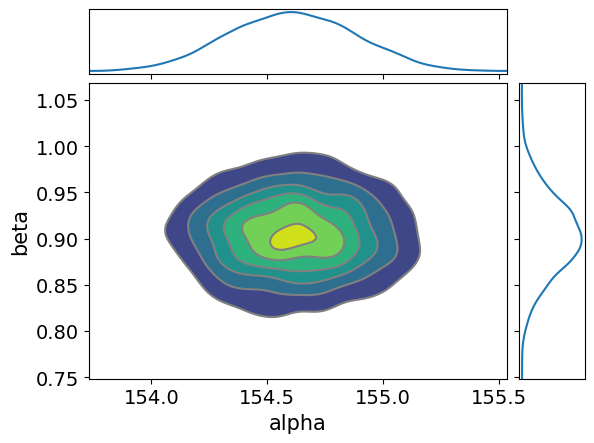

In [37]:
az.plot_pair(
    trace_posterior,
    var_names=['alpha', 'beta'],
    kind="kde",
    marginals=True
)

Got error No model on context stack. trying to find log_likelihood in translation.
/home/dmitri/.local/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:>, None],
       [<AxesSubplot:xlabel='alpha', ylabel='beta'>, <AxesSubplot:>]],
      dtype=object)

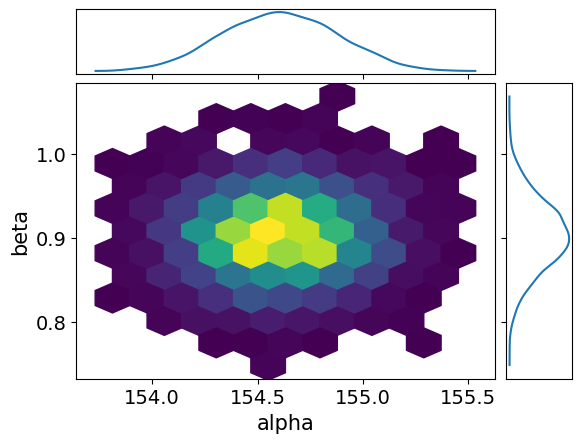

In [38]:
az.plot_pair(
    trace_posterior,
    var_names=['alpha', 'beta'],
    kind="hexbin",
    marginals=True
)

Posterior interval of 0.5 of probability.

In [39]:
az.summary(trace_posterior, hdi_prob=0.5)

Got error No model on context stack. trying to find log_likelihood in translation.
/home/dmitri/.local/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_25%,hdi_75%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,154.607,0.272,154.432,154.808,0.003,0.002,6291.0,3063.0,1.0
beta,0.903,0.042,0.873,0.929,0.001,0.000,5423.0,3142.0,1.0
sigma,5.101,0.198,4.952,5.218,0.003,0.002,5236.0,2932.0,1.0
mu[0],157.167,0.299,156.951,157.361,0.004,0.003,5738.0,2716.0,1.0
mu[1],146.925,0.446,146.606,147.219,0.006,0.004,5870.0,3423.0,1.0
...,...,...,...,...,...,...,...,...,...
mu[347],156.450,0.286,156.219,156.614,0.004,0.003,6037.0,2823.0,1.0
mu[348],144.903,0.524,144.457,145.171,0.007,0.005,5902.0,3373.0,1.0
mu[349],161.085,0.410,160.797,161.344,0.006,0.004,5157.0,2972.0,1.0
mu[350],162.800,0.473,162.516,163.129,0.007,0.005,5091.0,2759.0,1.0


Posterior predictive interval of 0.5 of probability for each person.

(Only show the first 10).

In [40]:
az.hdi(trace_height['height'], hdi_prob=0.5)[:10]

/tmp/ipykernel_4849/2526077738.py:1: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  az.hdi(trace_height['height'], hdi_prob=0.5)[:10]


array([[153.22648978, 160.12799772],
       [143.428799  , 150.31468186],
       [139.00420466, 145.64053866],
       [158.32241219, 165.23591516],
       [148.49329249, 155.44879545],
       [166.78969284, 173.72431183],
       [145.12082936, 151.92180872],
       [160.69536537, 167.53274773],
       [142.54863465, 149.44977243],
       [159.62831776, 166.34214097]])

## Regression for the population's height

Data

<AxesSubplot:xlabel='weight', ylabel='height'>

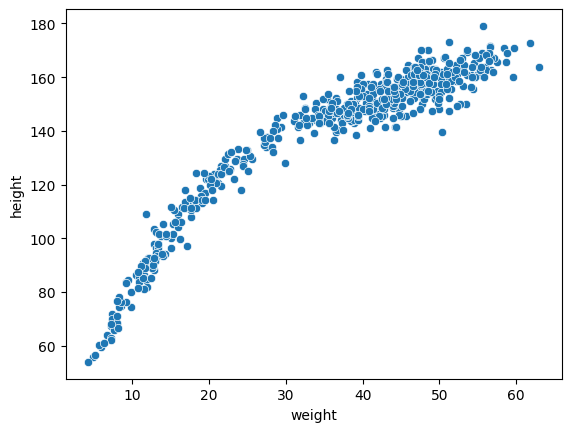

In [41]:
sns.scatterplot(data=dat, x='weight', y='height')

In [42]:
dat_weight_s = (dat['weight']-dat['weight'].mean())/dat['weight'].std()

Declare and fit the model.

In [43]:
with pm.Model() as model_height_weight_2:
    alpha    = pm.Normal('alpha', mu=170, sd=10)
    beta     = pm.Lognormal('beta', mu=0, sigma=1)
    sigma    = pm.Uniform('sigma', lower=0, upper=50)
    mu       = pm.Deterministic('mu', alpha + beta * dat_weight_s)
    height   = pm.Normal('height', mu=mu, sd=sigma, observed=dat['height'])

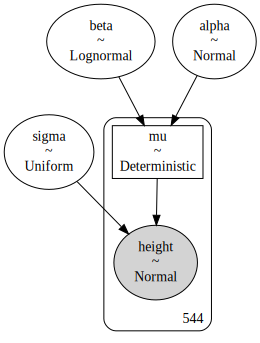

In [44]:
pm.model_to_graphviz(model_height_weight_2)

Using the normal approximation.

In [45]:
with model_height_weight_2:
    mean_q  = pm.find_MAP()
    IFisher = pm.find_hessian(mean_q, vars=[alpha, beta, sigma])

IFisher_inverse = np.linalg.inv(IFisher)

Sample from the approximate normal posterior.

In [46]:
posterior_sample = multivariate_normal.rvs(
    size=10**4,
    mean=np.array([mean_q['alpha'], mean_q['beta'], mean_q['sigma']]),
    cov=IFisher_inverse
    )

posterior_sample = pd.DataFrame(posterior_sample, columns=['alpha', 'beta', 'sigma'])

Estimating confidence intervals.

In [47]:
x_min      = dat['weight'].min()
x_max      = dat['weight'].max()
weight_seq = np.linspace(x_min, x_max)

In [48]:
ConfidenceIntervals = pd.DataFrame(
    np.quantile(posterior_sample['alpha']+posterior_sample['beta']*(x_min-dat['weight'].mean())/dat['weight'].std(), [0.025, 0.975]).reshape(1,2),
    columns=['LCI', 'UCI'])

In [49]:
for i in range(1, len(weight_seq)):
    ConfidenceIntervals = pd.concat(
        [ConfidenceIntervals,
         pd.DataFrame(
             np.quantile(posterior_sample['alpha']+posterior_sample['beta']*(weight_seq[i]-dat['weight'].mean())/dat['weight'].std(),
                         [0.025, 0.975]).reshape(1,2),
             columns=['LCI', 'UCI'])
          ])

In [50]:
ConfidenceIntervals['weight'] = weight_seq

Estimating prediction intervals

In [51]:
height_samp = norm.rvs(size=10**4,
             loc=posterior_sample['alpha']+posterior_sample['beta']*(x_min-dat['weight'].mean())/dat['weight'].std(),
             scale=posterior_sample['sigma'])

PredictionIntervals = pd.DataFrame(np.quantile(height_samp, [0.025, 0.975]).reshape(1,2), columns=['LPI', 'UPI'])

In [52]:
for i in range(1, len(weight_seq)):
    height_samp = norm.rvs(size=10**4,
             loc=posterior_sample['alpha']+posterior_sample['beta']*(weight_seq[i]-dat['weight'].mean())/dat['weight'].std(),
             scale=posterior_sample['sigma'])
    
    PredictionIntervals = pd.concat([PredictionIntervals,
                                     pd.DataFrame(np.quantile(height_samp, [0.025, 0.975]).reshape(1,2), columns=['LPI', 'UPI'])])

In [53]:
PredictionIntervals['weight'] = weight_seq

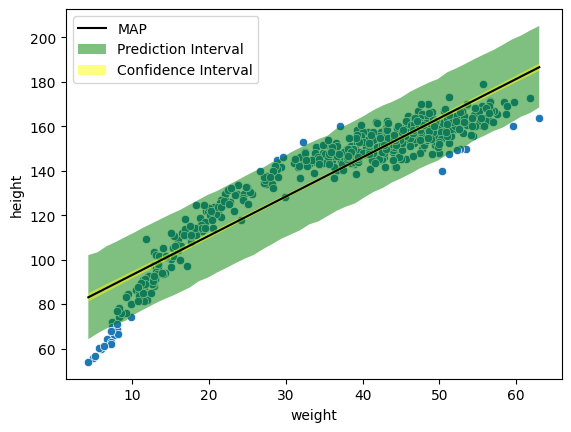

In [54]:
sns.scatterplot(data=dat, x='weight', y='height')

plt.plot([x_min, x_max],
         [mean_q['alpha']+mean_q['beta']*(x_min-dat['weight'].mean())/dat['weight'].std(),
          mean_q['alpha']+mean_q['beta']*(x_max-dat['weight'].mean())/dat['weight'].std()], color='k', label='MAP')

plt.fill_between(PredictionIntervals['weight'], PredictionIntervals['LPI'], PredictionIntervals['UPI'],
                 facecolor='green', alpha=0.5, label='Prediction Interval')

plt.fill_between(ConfidenceIntervals['weight'], ConfidenceIntervals['LCI'], ConfidenceIntervals['UCI'],
                 facecolor='yellow', alpha=0.5, label='Confidence Interval')
plt.legend()

Using MCMC

In [55]:
with model_height_weight_2:
    trace_posterior = pm.sample()

/tmp/ipykernel_4849/1503904627.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_posterior = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


Estimating confidence intervals.

In [56]:
ConfidenceIntervals = pd.DataFrame(
    np.quantile(trace_posterior['alpha']+trace_posterior['beta']*(x_min-dat['weight'].mean())/dat['weight'].std(), [0.025, 0.975]).reshape(1,2),
    columns=['LCI', 'UCI'])

In [57]:
for i in range(1, len(weight_seq)):
    ConfidenceIntervals = pd.concat(
        [ConfidenceIntervals,
         pd.DataFrame(
             np.quantile(trace_posterior['alpha']+trace_posterior['beta']*(weight_seq[i]-dat['weight'].mean())/dat['weight'].std(),
                         [0.025, 0.975]).reshape(1,2),
             columns=['LCI', 'UCI'])
          ])

In [58]:
ConfidenceIntervals['weight'] = weight_seq

Estimating prediction intervals

In [59]:
height_samp = norm.rvs(size=len(trace_posterior['alpha']),
             loc=trace_posterior['alpha']+trace_posterior['beta']*(x_min-dat['weight'].mean())/dat['weight'].std(),
             scale=trace_posterior['sigma'])

PredictionIntervals = pd.DataFrame(np.quantile(height_samp, [0.025, 0.975]).reshape(1,2), columns=['LPI', 'UPI'])

In [60]:
for i in range(1, len(weight_seq)):
    height_samp = norm.rvs(size=len(trace_posterior['alpha']),
             loc=trace_posterior['alpha']+trace_posterior['beta']*(weight_seq[i]-dat['weight'].mean())/dat['weight'].std(),
             scale=trace_posterior['sigma'])
    
    PredictionIntervals = pd.concat([PredictionIntervals,
                                     pd.DataFrame(np.quantile(height_samp, [0.025, 0.975]).reshape(1,2), columns=['LPI', 'UPI'])])

In [61]:
PredictionIntervals['weight'] = weight_seq

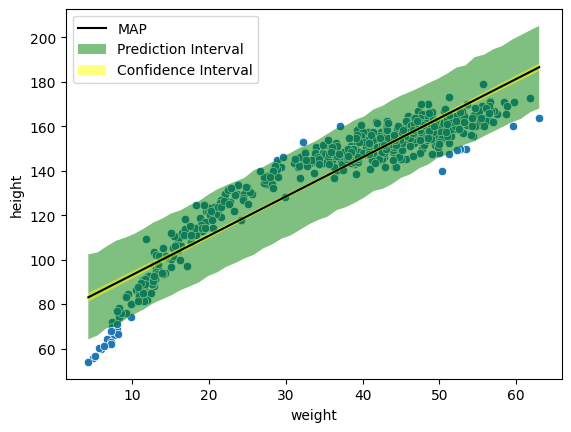

In [62]:
sns.scatterplot(data=dat, x='weight', y='height')

plt.plot([x_min, x_max],
         [mean_q['alpha']+mean_q['beta']*(x_min-dat['weight'].mean())/dat['weight'].std(),
          mean_q['alpha']+mean_q['beta']*(x_max-dat['weight'].mean())/dat['weight'].std()], color='k', label='MAP')

plt.fill_between(PredictionIntervals['weight'], PredictionIntervals['LPI'], PredictionIntervals['UPI'],
                 facecolor='green', alpha=0.5, label='Prediction Interval')

plt.fill_between(ConfidenceIntervals['weight'], ConfidenceIntervals['LCI'], ConfidenceIntervals['UCI'],
                 facecolor='yellow', alpha=0.5, label='Confidence Interval')
plt.legend()

### Regression for all population considering a quadratic polynomial

In [63]:
with pm.Model() as model_height_weight_3:
    alpha    = pm.Normal('alpha', mu=170, sd=10)
    beta1    = pm.Lognormal('beta1', mu=0, sigma=1)
    beta2    = pm.Normal('beta2', mu=0, sd=1)
    sigma    = pm.Uniform('sigma', lower=0, upper=50)
    mu       = pm.Deterministic('mu', alpha + beta1*dat_weight_s + beta2*dat_weight_s**2)
    height   = pm.Normal('height', mu=mu, sd=sigma, observed=dat['height'])

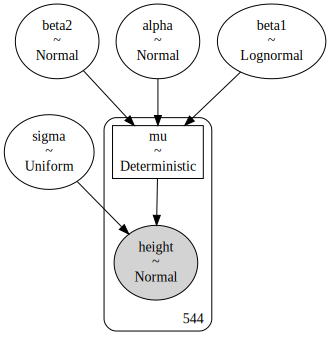

In [64]:
pm.model_to_graphviz(model_height_weight_3)

In [65]:
with model_height_weight_3:
    mean_q = pm.find_MAP()
    trace_posterior = pm.sample()

/tmp/ipykernel_4849/1661332936.py:3: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_posterior = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta2, beta1, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Estimating regression function (MAP)

In [66]:
regression_map = []

for i in range(len(weight_seq)):
    regression_map.append(mean_q['alpha'] + \
                         mean_q['beta1']*(weight_seq[i]-dat['weight'].mean())/dat['weight'].std() + \
                         mean_q['beta2']*((weight_seq[i]-dat['weight'].mean())/dat['weight'].std())**2)

RegressionMAP = pd.DataFrame(regression_map, columns=['regression'])
RegressionMAP['weight'] = weight_seq

Estimating confidence intervals

In [67]:
ConfidenceIntervals = pd.DataFrame(
    np.quantile(trace_posterior['alpha'] + \
                trace_posterior['beta1']*(x_min-dat['weight'].mean())/dat['weight'].std() + \
                trace_posterior['beta2']*((x_min-dat['weight'].mean())/dat['weight'].std())**2, [0.025, 0.975]).reshape(1,2),
    columns=['LCI', 'UCI'])

In [68]:
for i in range(1, len(weight_seq)):
    ConfidenceIntervals = pd.concat(
        [ConfidenceIntervals,
         pd.DataFrame(
             np.quantile(trace_posterior['alpha'] + \
                         trace_posterior['beta1']*(weight_seq[i]-dat['weight'].mean())/dat['weight'].std() + \
                         trace_posterior['beta2']*((weight_seq[i]-dat['weight'].mean())/dat['weight'].std())**2,
                         [0.025, 0.975]).reshape(1,2),
             columns=['LCI', 'UCI'])
          ])

In [69]:
ConfidenceIntervals['weight'] = weight_seq

Estimating prediction intervals

In [70]:
height_samp = norm.rvs(size=len(trace_posterior['alpha']),
             loc=trace_posterior['alpha'] + \
                trace_posterior['beta1']*(x_min-dat['weight'].mean())/dat['weight'].std() + \
                trace_posterior['beta2']*((x_min-dat['weight'].mean())/dat['weight'].std())**2,
             scale=trace_posterior['sigma'])

PredictionIntervals = pd.DataFrame(np.quantile(height_samp, [0.025, 0.975]).reshape(1,2), columns=['LPI', 'UPI'])

In [71]:
for i in range(1, len(weight_seq)):
    height_samp = norm.rvs(size=len(trace_posterior['alpha']),
             loc=trace_posterior['alpha'] + \
                trace_posterior['beta1']*(weight_seq[i]-dat['weight'].mean())/dat['weight'].std() + \
                trace_posterior['beta2']*((weight_seq[i]-dat['weight'].mean())/dat['weight'].std())**2,
             scale=trace_posterior['sigma'])
    
    PredictionIntervals = pd.concat([PredictionIntervals,
                                     pd.DataFrame(np.quantile(height_samp, [0.025, 0.975]).reshape(1,2), columns=['LPI', 'UPI'])])

In [72]:
PredictionIntervals['weight'] = weight_seq

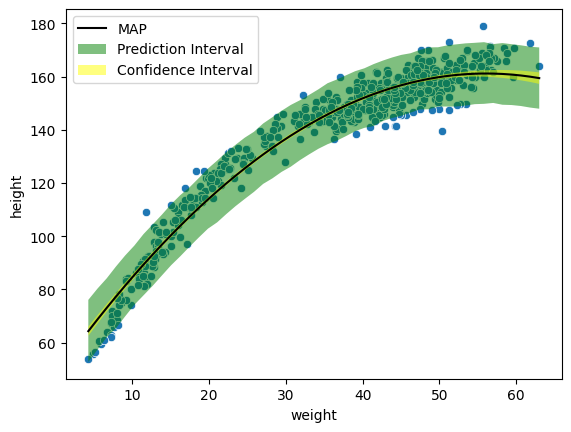

In [73]:
sns.scatterplot(data=dat, x='weight', y='height')

plt.plot(RegressionMAP['weight'], RegressionMAP['regression'], color='k', label='MAP')

plt.fill_between(PredictionIntervals['weight'], PredictionIntervals['LPI'], PredictionIntervals['UPI'],
                 facecolor='green', alpha=0.5, label='Prediction Interval')

plt.fill_between(ConfidenceIntervals['weight'], ConfidenceIntervals['LCI'], ConfidenceIntervals['UCI'],
                 facecolor='yellow', alpha=0.5, label='Confidence Interval')
plt.legend()